In [1]:
import numpy as np
from raftup import (
    _downsample,
    _fsgw_utils,
    _metrics_two_gpr,
    _load_data,
    _plot,
    _recoverfull_new_new_knn
)
from scipy.spatial import distance

random_state = 23
np.random.seed(random_state)

section_ids_list = [['-0.04', '-0.09']]
pair = "m0p04_m0p09"
ds_pts = 200

for section_ids in section_ids_list:
    dataset = section_ids[0] + '_' + section_ids[1]

    sliceA = _load_data.load_mHypothalamus(section_id=section_ids[0])
    sliceB = _load_data.load_mHypothalamus(section_id=section_ids[1])


D_A = distance.cdist(sliceA.obsm['spatial'], sliceA.obsm['spatial'])
D_B = distance.cdist(sliceB.obsm['spatial'], sliceB.obsm['spatial'])
TestA = D_A[D_A>0]
TestB = D_B[D_B>0]
print(np.min(TestA), np.min(TestB), np.max(TestA), np.max(TestB))

/opt/anaconda3/envs/raftup_env/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/raftup_env/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/anaconda3/envs/raftup_env/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


3.235455771330554 2.1911319540983416 2494.720899495855 2498.44176091063


/opt/anaconda3/envs/raftup_env/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [2]:
downsampled_sliceA,indices_dsa = _downsample.maxmin_downsample_slice_merfish(sliceA, ds_pts)
downsampled_sliceB,indices_dsb = _downsample.maxmin_downsample_slice_merfish(sliceB, ds_pts)

D_A_test = distance.cdist(downsampled_sliceA.obsm['spatial'], downsampled_sliceA.obsm['spatial'])
D_B_test = distance.cdist(downsampled_sliceB.obsm['spatial'], downsampled_sliceB.obsm['spatial'])
testA = D_A_test[D_A_test>0]
testB = D_B_test[D_B_test>0]
slice_scale = np.min([np.max(testA), np.max(testB)])
print(np.min(testA), np.min(testB), np.max(testA), np.max(testB))

98.50759140234227 97.67900930377812 2485.288735388629 2498.44176091063


/Users/salovjade/Library/CloudStorage/Dropbox/raftup_repo/src/raftup/_downsample.py:302: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "spatial" not in sliceA.obsm_keys():


In [3]:
# np.savetxt("indices_dsa.csv", indices_dsa, delimiter=",", fmt="%d")
# np.savetxt("indices_dsb.csv", indices_dsb, delimiter=",", fmt="%d")

In [4]:
from pathlib import Path
import numpy as np

cutoff_GW = int(np.max([np.min(testA), np.min(testB)]))
print(cutoff_GW)

cutoff_CC = 0.1

SAVE_DIR = Path("align_data")

load_path = SAVE_DIR / f"ds_matching_{pair}_{cutoff_GW}_{cutoff_CC}.csv"

P = np.loadtxt(load_path, delimiter=",")

98


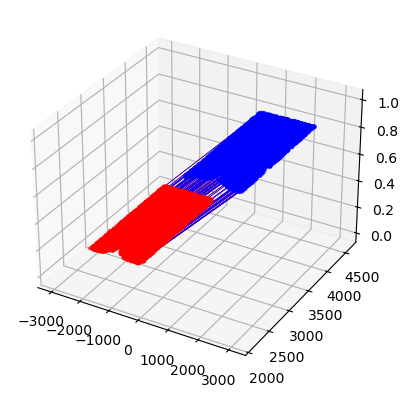

In [6]:
L_sig, L_full, indices_A_matched, indices_B_matched= _recoverfull_new_new_knn.generate_binary_matching(sliceA, downsampled_sliceA, sliceB, downsampled_sliceB, P, cutoff_GW, cutoff_CC, SAVE_DIR)

_plot.plot_3d(sliceA.obsm['spatial'], sliceB.obsm['spatial'], L_sig, indices_A_matched, indices_B_matched, linewidth=0.5)

In [8]:
import pandas as pd

M_full = np.array( pd.read_csv(f"/Users/salovjade/Library/CloudStorage/Dropbox/RAFTUP_after0320/mHypothalamus/feature_{pair}_not_normalized.csv", header=None) )

test_label_full = np.concatenate((np.array(sliceA.obs['original_clusters']),np.array(sliceB.obs['original_clusters'])),axis=0)
XA_full = sliceA.obsm['spatial']
XB_full = sliceB.obsm['spatial']

thresh_CCC_list = {0.1}
thresh_CGW_list = {80}

for thresh_CCC in thresh_CCC_list:
    for thresh_CGW in thresh_CGW_list:
        print(f"Running alignment for {section_ids} with {thresh_CGW} and {thresh_CCC}")
        P_full_knn = _recoverfull_new_new_knn.recover_full_mapping_knn(
            M = M_full,
            X1 = sliceA.obsm['spatial'],
            X2 = sliceB.obsm['spatial'],
            P  = L_sig,
            idx1 = indices_A_matched,
            idx2 = indices_B_matched,
            k1 = 4,         # sliceA 侧用的锚点邻域
            k2 = 4,         # sliceB 侧用的锚点邻域
            thresh_CGW=thresh_CGW, 
            thresh_CCC=thresh_CCC, 
            eps=0.01
        )
        P_full_dense_knn = P_full_knn.toarray()

        full_LAA = _metrics_two_gpr.cal_layer_based_alignment_result_merfish_skill_all_zero(P_full_dense_knn, test_label_full)
        full_GPR_15= _metrics_two_gpr.GPR_original(P_full_dense_knn, XA_full, XB_full, dis_cut=15, P_cut=1e-20)
        full_GPR_30= _metrics_two_gpr.GPR_original(P_full_dense_knn, XA_full, XB_full, dis_cut=30, P_cut=1e-20)
        full_GPR_45= _metrics_two_gpr.GPR_original(P_full_dense_knn, XA_full, XB_full, dis_cut=45, P_cut=1e-20)

        print(f"full_LAA for {section_ids}):", full_LAA)

        print("full_GPR_15:", full_GPR_15)
        print("full_GPR_30:", full_GPR_30)
        print("full_GPR_45:", full_GPR_45)
        print("---------------------------------------------------------------")
        np.save(f'align_data/full_matching_{pair}_{thresh_CGW}_{thresh_CCC}_0108_copycopy.npy',P_full_dense_knn)

Running alignment for ['-0.04', '-0.09'] with 80 and 0.1


recover_full_mapping_knn:  75%|███████▌  | 6/8 [04:16<01:24, 42.05s/it]

Number of blocked positions in recover_full sOT (kNN): 30340536
Number of possible aligned positions (kNN): 156280


Number of iterations in unot: 20001, final error: 2.14e-07
full_LAA for ['-0.04', '-0.09']): 0.7598334104581213
full_GPR_15: 0.540920091819092
full_GPR_30: 0.44612445004046214
full_GPR_45: 0.5096504177689107
---------------------------------------------------------------
